# Panoliaskos (1985): Prediction of Optical Fiber Coating Thickness
## Step-by-step reproduction + engineering implementation

**Goal:** Reproduce the analysis in the paper, verify assumptions, and build a reusable calculator for coating thickness in a cylindrical die.

**Scope of this notebook**
- Follow the paper step-by-step (equations and assumptions)
- Insert real parameters from coating datasheets only when needed
- Produce verified functions that can be reused in tower software

**Units policy**
- Inputs shown in operator-friendly units (e.g., bar, µm, m/min)
- All calculations performed internally in SI units

## Abstract

This notebook reproduces the analytical model presented by Panoliaskos (1985) for predicting optical fiber coating thickness in a cylindrical die.

The model treats the coating liquid as a Newtonian fluid in steady, laminar, fully developed annular flow between a moving fiber and a stationary die wall. The velocity profile is a superposition of Couette (drag-driven) and Poiseuille (pressure-driven) contributions. The volumetric flow rate is obtained from the velocity profile, and coating thickness is determined by mass conservation.

The analysis predicts thickness as a function of draw speed $V$, cup pressure $\Delta p$, die geometry $(R, L)$, radius ratio $k=r_f/R$, and viscosity $\mu(T)$. The validity of the fully developed laminar assumption is evaluated using the Reynolds number and entrance length criteria. Real coating viscosity $\mu(T)$ is provided using fitted VFT models, and density $\rho$ is taken from datasheets.

The final outcome is a verified, implementation-ready thickness predictor with clear regime interpretation and parameter sensitivity, suitable for integration into draw-tower process tools.

## Paper roadmap (what we implement)

1. **Assumptions + validity checks**  
   - Reynolds number (laminar condition)  
   - Entrance length (fully developed condition)

2. **Velocity profile inside the annulus**  
   - Boundary conditions at fiber and die wall  
   - Expression for $u(r)$

3. **Volumetric flow rate**  
   - Compute $Q = 2\pi \int u(r)\, r\,dr$

4. **Thickness prediction from mass conservation**  
   - Solve for cured thickness $t$ using loading factor $q$

5. **Regimes and sensitivity**  
   - Interpret dimensionless pressure parameter $\Phi$  
   - Explore speed/pressure/temperature effects

## Step 1 — Validity of the model (Eq. 1 and Eq. 2)

The paper assumes that flow inside the nozzle is:
1. **Laminar** (low Reynolds number)
2. **Fully developed** (no entrance effects over most of the nozzle length)

### Reynolds number (Eq. 2)

$$
\mathrm{Re} = \frac{2\,\rho\,V\,R\,(1-k)}{\mu}
$$

where:
- $\rho$ is coating density
- $\mu$ is coating viscosity
- $V$ is fiber speed
- $R$ is nozzle radius
- $k = r_f/R$

### Entrance length (Eq. 1)

The entrance length estimate is:

$$
L_e = 0.0119\,R\left(\frac{1}{k} - k\right)\mathrm{Re}
$$

If $L \gg L_e$, the flow in most of the nozzle is fully developed and the velocity profile $u(r)$ may be treated as independent of axial position.

In [25]:
import numpy as np
import coating_viscosity_models as cvm  # your helper with VFT + densities

def reynolds_number(rho_kg_m3, mu_pa_s, V_m_s, R_m, k):
    # Eq.(2)
    return 2.0 * rho_kg_m3 * V_m_s * R_m * (1.0 - k) / mu_pa_s

def entrance_length_Le(R_m, k, Re):
    # Eq.(1) (paper estimate)
    return 0.0119 * R_m * ((1.0 / k) - k) * Re

def check_validity(
    coating: str,
    T_C: float,
    V_m_min: float,
    delta_p_bar: float,   # not used yet (later steps)
    R_um: float,
    L_um: float,
    fiber_d_um: float
):
    # ---- units ----
    V_m_s = V_m_min / 60.0
    R_m = R_um * 1e-6
    L_m = L_um * 1e-6
    rf_m = (fiber_d_um / 2.0) * 1e-6
    k = rf_m / R_m

    # ---- datasheet/material ----
    rho = cvm.get_density_kg_m3(coating)                 # kg/m^3
    mu = float(cvm.get_viscosity_pa_s(coating, T_C))     # Pa·s

    Re = reynolds_number(rho, mu, V_m_s, R_m, k)
    Le = entrance_length_Le(R_m, k, Re)

    print("==============================================")
    print("Step 1: Validity checks (Eq.1 & Eq.2)")
    print("----------------------------------------------")
    print(f"Coating      : {coating}")
    print(f"T            : {T_C:.1f} °C")
    print(f"ρ (datasheet): {rho:.1f} kg/m³")
    print(f"μ(T)         : {mu*1e3:.1f} mPa·s  ({mu:.4g} Pa·s)")
    print("")
    print(f"V            : {V_m_min:.2f} m/min  ({V_m_s:.4g} m/s)")
    print(f"R            : {R_um:.2f} µm")
    print(f"L            : {L_um:.2f} µm")
    print(f"fiber d      : {fiber_d_um:.2f} µm")
    print(f"k = rf/R     : {k:.5f}")
    print("----------------------------------------------")
    print(f"Re (Eq.2)    : {Re:.4g}")
    print(f"Le (Eq.1)    : {Le*1e6:.4g} µm")
    print(f"Le/L         : {(Le/L_m):.4g}")
    print("----------------------------------------------")
    print(f"Laminar (Re<1): {'✅ OK' if Re < 1 else '⚠️ CHECK'}")
    print(f"Developed (Le/L<0.1): {'✅ OK' if (Le/L_m) < 0.1 else '⚠️ CHECK'}")
    print("==============================================")

    return {"Re": Re, "Le_over_L": Le/L_m, "k": k, "mu_pa_s": mu, "rho": rho}

# Example run (edit to your real nozzle/fiber)
check_validity(
    coating="DP-1032",
    T_C=28.0,
    V_m_min=100.0,
    delta_p_bar=0.5,  # not used yet
    R_um=65.0,
    L_um=20000.0,
    fiber_d_um=40.0
)

Step 1: Validity checks (Eq.1 & Eq.2)
----------------------------------------------
Coating      : DP-1032
T            : 28.0 °C
ρ (datasheet): 1055.0 kg/m³
μ(T)         : 3646.2 mPa·s  (3.646 Pa·s)

V            : 100.00 m/min  (1.667 m/s)
R            : 65.00 µm
L            : 20000.00 µm
fiber d      : 40.00 µm
k = rf/R     : 0.30769
----------------------------------------------
Re (Eq.2)    : 0.0434
Le (Eq.1)    : 0.09878 µm
Le/L         : 4.939e-06
----------------------------------------------
Laminar (Re<1): ✅ OK
Developed (Le/L<0.1): ✅ OK


{'Re': 0.043401939277206675,
 'Le_over_L': 4.938869427625637e-06,
 'k': 0.3076923076923077,
 'mu_pa_s': 3.6461504401741767,
 'rho': 1055.0}

## Step 2 — Velocity profile in the annulus (Couette–Poiseuille superposition)

After verifying $\mathrm{Re}\ll 1$ and $L \gg L_e$, the paper assumes **steady, fully developed, laminar annular flow** inside the nozzle.

### Geometry and boundary conditions

Let:
- nozzle radius: $R$
- fiber radius: $r_f = kR$ (so $k = r_f/R$)
- axial velocity: $u(r)$
- fiber (inner boundary) moves at speed $V$

Boundary conditions:
- No-slip at the nozzle wall:  $$u(R)=0$$
- No-slip at the fiber surface: $$u(kR)=V$$

### Pressure–drag competition

The paper introduces the dimensionless pressure parameter:

$$
\Phi = \frac{\Delta p\, R^2}{8\,\mu\,L\,V}
$$

This controls the relative importance of:
- Poiseuille component (pressure-driven)
- Couette component (drag-driven)

### Velocity profile (paper result)

Using the above assumptions and boundary conditions, the velocity profile in the annulus can be written in normalized form:

$$
\frac{u(r)}{V} =
2\Phi\left[1-\left(\frac{r}{R}\right)^2 - (1-k^2)\frac{\ln(r/R)}{\ln(k)}\right]
+
\frac{\ln(r/R)}{\ln(k)}
$$

This expression will be implemented directly and later integrated to obtain the volumetric flow rate:

$$
Q = 2\pi\int_{kR}^{R} u(r)\,r\,dr
$$

Step 2: Velocity profile sanity checks
--------------------------------------
k = 0.30769
Phi = 0.0002173
u(kR) ≈ 1.66667 m/s    (target ≈ V = 1.66667 m/s)
u(R)  ≈ 0 m/s    (target ≈ 0)
--------------------------------------


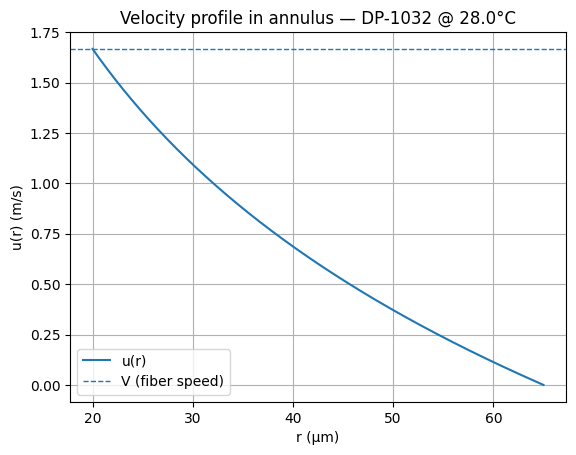

{'k': 0.3076923076923077,
 'Phi': 0.00021726681687938169,
 'u_inner': 1.6666666666666667,
 'u_outer': 0.0}

In [26]:
import numpy as np
import coating_viscosity_models as cvm

def phi_from_bar(delta_p_bar: float, R_m: float, L_m: float, mu_pa_s: float, V_m_s: float) -> float:
    """
    Φ = Δp R^2 / (8 μ L V)
    Inputs:
        delta_p_bar : pressure in bar (tower unit)
        R_m, L_m    : meters
        mu_pa_s     : Pa·s
        V_m_s       : m/s
    """
    delta_p_pa = delta_p_bar * 1e5  # bar -> Pa
    return (delta_p_pa * R_m**2) / (8.0 * mu_pa_s * L_m * V_m_s)

def u_profile(r_m: np.ndarray, R_m: float, k: float, V_m_s: float, Phi: float) -> np.ndarray:
    """
    Paper velocity profile:

    u/V = 2Φ[ 1 - (r/R)^2 - (1-k^2)*ln(r/R)/ln(k) ] + ln(r/R)/ln(k)
    """
    x = r_m / R_m
    lnk = np.log(k)
    return V_m_s * (2.0*Phi*(1.0 - x**2 - (1.0 - k**2)*np.log(x)/lnk) + np.log(x)/lnk)

def show_velocity_profile(
    coating="DP-1032",
    T_C=28.0,
    V_m_min=100.0,
    delta_p_bar=0.50,
    R_um=65.0,
    L_um=20000.0,
    fiber_d_um=40.0
):
    # ---- units ----
    V_m_s = V_m_min / 60.0
    R_m = R_um * 1e-6
    L_m = L_um * 1e-6
    rf_m = (fiber_d_um / 2.0) * 1e-6
    k = rf_m / R_m

    # ---- materials ----
    mu_pa_s = float(cvm.get_viscosity_pa_s(coating, T_C))
    Phi = phi_from_bar(delta_p_bar, R_m, L_m, mu_pa_s, V_m_s)

    # ---- compute profile ----
    r = np.linspace(k*R_m, R_m, 1200)
    u = u_profile(r, R_m, k, V_m_s, Phi)

    # ---- quick sanity checks on BCs ----
    u_inner = float(u[0])
    u_outer = float(u[-1])

    print("Step 2: Velocity profile sanity checks")
    print("--------------------------------------")
    print(f"k = {k:.5f}")
    print(f"Phi = {Phi:.4g}")
    print(f"u(kR) ≈ {u_inner:.6g} m/s    (target ≈ V = {V_m_s:.6g} m/s)")
    print(f"u(R)  ≈ {u_outer:.6g} m/s    (target ≈ 0)")
    print("--------------------------------------")

    # ---- plot ----
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(r*1e6, u, label="u(r)")
    plt.axhline(V_m_s, linestyle="--", linewidth=1, label="V (fiber speed)")
    plt.xlabel("r (µm)")
    plt.ylabel("u(r) (m/s)")
    plt.title(f"Velocity profile in annulus — {coating} @ {T_C:.1f}°C")
    plt.grid(True)
    plt.legend()
    plt.show()

    return {"k": k, "Phi": Phi, "u_inner": u_inner, "u_outer": u_outer}

# Run Step 2 once with your real-ish values (edit as needed)
show_velocity_profile()

## Step 3 — Volumetric flow rate $Q$

Once the annular velocity profile $u(r)$ is known, the paper computes the **volumetric flow rate** through the nozzle by integrating across the annulus:

$$
Q = 2\pi \int_{kR}^{R} u(r)\,r\,dr
$$

This step connects the hydrodynamics (pressure + drag) to the amount of liquid delivered.

**Key expectation:**
- Increasing $\Delta p$ (thus increasing $\Phi$) increases $Q$.
- Increasing viscosity $\mu(T)$ decreases $\Phi$ and typically decreases $Q$ for the same $\Delta p$.
- Increasing speed $V$ changes both the drag term and also appears inside $\Phi$ (so the dependence is not trivial).

In [28]:
import numpy as np
import coating_viscosity_models as cvm

# --- from Step 2 (keep these definitions in the notebook) ---
def phi_from_bar(delta_p_bar: float, R_m: float, L_m: float, mu_pa_s: float, V_m_s: float) -> float:
    delta_p_pa = delta_p_bar * 1e5
    return (delta_p_pa * R_m**2) / (8.0 * mu_pa_s * L_m * V_m_s)

def u_profile(r_m: np.ndarray, R_m: float, k: float, V_m_s: float, Phi: float) -> np.ndarray:
    x = r_m / R_m
    lnk = np.log(k)
    return V_m_s * (2.0*Phi*(1.0 - x**2 - (1.0 - k**2)*np.log(x)/lnk) + np.log(x)/lnk)

# --- Step 3: Q integration ---
def flow_rate_Q(R_m: float, k: float, V_m_s: float, Phi: float, n: int = 6000) -> float:
    """
    Q = 2π ∫ u(r) r dr from r=kR to R   [m^3/s]
    Numerical integration (trapz) is robust and matches the paper definition directly.
    """
    r = np.linspace(k*R_m, R_m, n)
    u = u_profile(r, R_m, k, V_m_s, Phi)
    return 2.0 * np.pi * np.trapezoid(u * r, r)

def compute_Q_case(
    coating="DP-1032",
    T_C=28.0,
    V_m_min=100.0,
    delta_p_bar=0.50,
    R_um=65.0,
    L_um=20000.0,
    fiber_d_um=40.0
):
    # --- units ---
    V_m_s = V_m_min / 60.0
    R_m = R_um * 1e-6
    L_m = L_um * 1e-6
    rf_m = (fiber_d_um / 2.0) * 1e-6
    k = rf_m / R_m

    # --- materials ---
    mu_pa_s = float(cvm.get_viscosity_pa_s(coating, T_C))
    Phi = phi_from_bar(delta_p_bar, R_m, L_m, mu_pa_s, V_m_s)

    # --- flow rate ---
    Q = flow_rate_Q(R_m, k, V_m_s, Phi)

    # pretty outputs
    Q_uL_s = Q * 1e9  # 1 m^3/s = 1e9 µL/s
    print("Step 3: Flow rate Q")
    print("--------------------------------------")
    print(f"Coating       : {coating} @ {T_C:.1f} °C")
    print(f"μ(T)          : {mu_pa_s*1e3:.1f} mPa·s")
    print(f"V             : {V_m_min:.2f} m/min ({V_m_s:.4g} m/s)")
    print(f"Δp            : {delta_p_bar:.3f} bar")
    print(f"R, L          : {R_um:.2f} µm, {L_um:.0f} µm")
    print(f"fiber d       : {fiber_d_um:.2f} µm  -> k={k:.5f}")
    print(f"Φ             : {Phi:.4g}")
    print(f"Q             : {Q:.4g} m³/s  ({Q_uL_s:.3f} µL/s)")
    print("--------------------------------------")
    return {"Q_m3_s": Q, "Q_uL_s": Q_uL_s, "Phi": Phi, "k": k, "mu_pa_s": mu_pa_s}

# Run once
outQ = compute_Q_case()
outQ

Step 3: Flow rate Q
--------------------------------------
Coating       : DP-1032 @ 28.0 °C
μ(T)          : 3646.2 mPa·s
V             : 100.00 m/min (1.667 m/s)
Δp            : 0.500 bar
R, L          : 65.00 µm, 20000 µm
fiber d       : 40.00 µm  -> k=0.30769
Φ             : 0.0002173
Q             : 6.403e-09 m³/s  (6.403 µL/s)
--------------------------------------


{'Q_m3_s': np.float64(6.403003600465972e-09),
 'Q_uL_s': np.float64(6.403003600465972),
 'Phi': 0.00021726681687938169,
 'k': 0.3076923076923077,
 'mu_pa_s': 3.6461504401741767}

## Step 4 — Coating thickness from mass conservation (loading factor $q$)

The paper converts the volumetric flow rate $Q$ into a **cured coating thickness** $t$ using mass conservation.

Let:
- fiber radius: $r_f$
- cured coating thickness: $t$
- draw speed: $V$
- loading factor: $q$ (accounts for shrinkage / density change between liquid and cured coating)

The cross-sectional area of the cured coating annulus is:

$$
A_c = \pi\left[(r_f+t)^2 - r_f^2\right]
$$

The volumetric rate of cured coating carried by the fiber is:

$$
Q_{\text{cured}} = q\,V\,A_c
$$

Mass conservation implies:

$$
Q = q\,\pi V\left[(r_f+t)^2 - r_f^2\right]
$$

We will solve this equation for $t \ge 0$.

In [48]:
import numpy as np
import coating_viscosity_models as cvm

# ============================================================
# Reynolds number (Paper Eq.2)
# ============================================================

def reynolds_number(rho_kg_m3: float, mu_pa_s: float, V_m_s: float, R_m: float, k: float) -> float:
    return 2.0 * rho_kg_m3 * V_m_s * R_m * (1.0 - k) / mu_pa_s


# ============================================================
# Thickness from Q (mass conservation)
# ============================================================

def thickness_from_Q(Q_m3_s: float, V_m_s: float, rf_m: float, q: float = 1.0) -> float:
    inside = rf_m**2 + (Q_m3_s / (q * np.pi * V_m_s))
    return np.sqrt(inside) - rf_m


# ============================================================
# Single-layer solver
# ============================================================

def solve_single_layer(
    coating: str,
    T_C: float,
    V_m_s: float,
    delta_p_bar: float,
    R_um: float,
    L_um: float,
    r_inner_m: float,
    q: float = 1.0,
    n_int: int = 6000,
):
    R_m = R_um * 1e-6
    L_m = L_um * 1e-6
    k = r_inner_m / R_m

    if not (0 < k < 1):
        raise ValueError(f"Invalid k={k:.5f}. Need 0<k<1.")

    mu_pa_s = float(cvm.get_viscosity_pa_s(coating, T_C))
    rho = float(cvm.get_density_kg_m3(coating))

    Phi = phi_from_bar(delta_p_bar, R_m, L_m, mu_pa_s, V_m_s)
    Q_m3_s = flow_rate_Q(R_m, k, V_m_s, Phi, n=n_int)

    t_m = thickness_from_Q(Q_m3_s, V_m_s, r_inner_m, q=q)

    Re = reynolds_number(rho, mu_pa_s, V_m_s, R_m, k)

    return {
        "t_m": t_m,
        "Phi": Phi,
        "Q_m3_s": Q_m3_s,
        "mu_pa_s": mu_pa_s,
        "rho": rho,
        "k": k,
        "Re": Re,
        "R_m": R_m,
        "L_m": L_m,
    }


# ============================================================
# Two-layer predictor
# ============================================================

def predict_two_layer_case(
    fiber_d_um: float = 40.0,
    V_m_min: float = 10.0,

    # ---- Layer 1 ----
    coating1: str = "DP-1032",
    T1_C: float = 28.0,
    delta_p1_bar: float = 0.5,
    R1_um: float = 65.0,
    L1_um: float = 2000.0,
    q1: float = 1.0,

    # ---- Layer 2 ----
    coating2: str = "DS-2042",
    T2_C: float = 28.0,
    delta_p2_bar: float = 0.5,
    R2_um: float = 90.0,
    L2_um: float = 2000.0,
    q2: float = 1.0,

    verbose: bool = True
):
    V_m_s = V_m_min / 60.0
    rf_m = (fiber_d_um / 2.0) * 1e-6

    # =========================
    # Layer 1
    # =========================
    res1 = solve_single_layer(
        coating1, T1_C, V_m_s,
        delta_p1_bar, R1_um, L1_um,
        r_inner_m=rf_m,
        q=q1
    )

    r_after_1_m = rf_m + res1["t_m"]

    # =========================
    # Layer 2
    # =========================
    res2 = solve_single_layer(
        coating2, T2_C, V_m_s,
        delta_p2_bar, R2_um, L2_um,
        r_inner_m=r_after_1_m,
        q=q2
    )

    # =========================
    # Final geometry
    # =========================
    t1_um = res1["t_m"] * 1e6
    t2_um = res2["t_m"] * 1e6
    final_od_um = 2.0 * (rf_m + res1["t_m"] + res2["t_m"]) * 1e6

    if verbose:
        def _uL_s(Q_m3_s): return Q_m3_s * 1e9

        print("======================================================")
        print("Two-layer coating prediction (with Reynolds)")
        print("------------------------------------------------------")
        print(f"Fiber diameter        : {fiber_d_um:.2f} µm")
        print(f"Draw speed            : {V_m_min:.2f} m/min ({V_m_s:.4g} m/s)")
        print("")
        print("Layer 1 (Primary)")
        print(f"  Coating             : {coating1}")
        print(f"  μ(T)                : {res1['mu_pa_s']*1e3:.1f} mPa·s")
        print(f"  ρ                   : {res1['rho']:.1f} kg/m³")
        print(f"  k                   : {res1['k']:.5f}")
        print(f"  Re1                 : {res1['Re']:.4g}")
        print(f"  Φ1                  : {res1['Phi']:.4g}")
        print(f"  Q1                  : {_uL_s(res1['Q_m3_s']):.3f} µL/s")
        print(f"  t1                  : {t1_um:.3f} µm")
        print("")
        print("Layer 2 (Secondary)")
        print(f"  Coating             : {coating2}")
        print(f"  μ(T)                : {res2['mu_pa_s']*1e3:.1f} mPa·s")
        print(f"  ρ                   : {res2['rho']:.1f} kg/m³")
        print(f"  k                   : {res2['k']:.5f}")
        print(f"  Re2                 : {res2['Re']:.4g}")
        print(f"  Φ2                  : {res2['Phi']:.4g}")
        print(f"  Q2                  : {_uL_s(res2['Q_m3_s']):.3f} µL/s")
        print(f"  t2                  : {t2_um:.3f} µm")
        print("")
        print(f"Final OD              : {final_od_um:.3f} µm")
        print("------------------------------------------------------")
        print(f"Laminar L1 (Re<1)     : {'OK' if res1['Re'] < 1 else 'CHECK'}")
        print(f"Laminar L2 (Re<1)     : {'OK' if res2['Re'] < 1 else 'CHECK'}")
        print("======================================================")

    return {
        "t1_um": t1_um,
        "t2_um": t2_um,
        "OD_um": final_od_um,
        "Re1": res1["Re"],
        "Re2": res2["Re"],
        "Phi1": res1["Phi"],
        "Phi2": res2["Phi"],
    }


# ============================================================
# Example run
# ============================================================

predict_two_layer_case()

Two-layer coating prediction (with Reynolds)
------------------------------------------------------
Fiber diameter        : 40.00 µm
Draw speed            : 10.00 m/min (0.1667 m/s)

Layer 1 (Primary)
  Coating             : DP-1032
  μ(T)                : 3646.2 mPa·s
  ρ                   : 1055.0 kg/m³
  k                   : 0.30769
  Re1                 : 0.00434
  Φ1                  : 0.02173
  Q1                  : 0.654 µL/s
  t1                  : 20.617 µm

Layer 2 (Secondary)
  Coating             : DS-2042
  μ(T)                : 4571.2 mPa·s
  ρ                   : 1130.0 kg/m³
  k                   : 0.45130
  Re2                 : 0.004069
  Φ2                  : 0.03322
  Q2                  : 1.281 µL/s
  t2                  : 23.391 µm

Final OD              : 128.017 µm
------------------------------------------------------
Laminar L1 (Re<1)     : OK
Laminar L2 (Re<1)     : OK


{'t1_um': np.float64(20.617139307311056),
 't2_um': np.float64(23.391128031877276),
 'OD_um': np.float64(128.01653467837667),
 'Re1': 0.004340193927720666,
 'Re2': np.float64(0.004069133865931663),
 'Phi1': 0.021726681687938173,
 'Phi2': 0.0332242231567873}

## Step (Eq. 12–14) — Surface tension vs viscous forces: $F_S/F_V$

Before proceeding, the paper checks whether **surface tension at the die exit** is negligible compared with the **viscous forces inside the nozzle**.

This is a *model validity check*:  
If $F_S/F_V \ll 1$, surface tension can be ignored in the thickness prediction.

---

### Geometry and definitions

- Nozzle radius: $R$
- Nozzle length: $L$
- Fiber radius: $r_f = kR$  (so $k = r_f/R$)
- Wet coating thickness at die exit: $t$
- Surface tension: $\sigma$ [$\mathrm{N/m}$]
- Viscosity: $\mu$ [$\mathrm{Pa \cdot s}$]
- Draw speed: $V$ [$\mathrm{m/s}$]
- Wall shear stress: $\tau_w$ [$\mathrm{Pa}$]

---

### Eq. (12): Surface-tension force

Surface tension acts around the circumference of the wet-coated fiber at the die exit:

$$
F_S = 2\pi \sigma (r_f + t)
$$

Since $r_f = kR$:

$$
F_S = 2\pi \sigma (kR + t)
$$

---

### Eq. (13): Viscous force

The viscous force resisting motion is the wall shear stress integrated over the internal die surface:

$$
F_V = 2\pi R L \, \tau_w
$$

---

### Wall shear stress definition

The wall shear stress is defined from the velocity gradient at the wall:

$$
\tau_w = \mu \left.\frac{du}{dr}\right|_{r=R}
$$

---

### Key ratio (surface vs viscous importance)

$$
\frac{F_S}{F_V}
$$

Interpretation:

- If $\frac{F_S}{F_V} \ll 1$ → surface tension is negligible.
- If $\frac{F_S}{F_V} \sim 1$ or larger → surface tension may influence the flow.

---

### Eq. (14): Drag-only simplification

In the drag-dominated limit ($\Phi = 0$), the paper simplifies the ratio into a closed-form expression (Eq. 14).

In this notebook, instead of using the simplified form, we compute:

$$
\tau_w = \mu \left.\frac{du}{dr}\right|_{r=R}
$$

directly from the full velocity profile (valid for any $\Phi$), and then evaluate:

$$
\frac{F_S}{F_V}
$$

numerically.

## Derivation of Eq. (14) for $\Phi=0$ (drag-only)

From the paper:

- Surface-tension force (Eq. 12):
$$
F_S = 2\pi \sigma (kR+t),
$$
where $\sigma$ is surface tension and $t$ here is the **wet** thickness ($q=1$). [oai_citation:1‡ao-24-15-2309.pdf](sediment://file_000000008358722f9ad5fcf5d6cc79d0)

- Viscous force at the nozzle wall (Eq. 13):
$$
F_V = 2\pi R L\,\tau_w,
$$
with $\tau_w$ the wall shear stress at $r=R$. [oai_citation:2‡ao-24-15-2309.pdf](sediment://file_000000008358722f9ad5fcf5d6cc79d0)

### Step 1 — Drag-only velocity profile

From the paper’s annulus solution (Eq. 5), setting $\Phi=0$ removes the pressure-driven term and leaves the Couette (drag) term:
$$
u(r)=V\frac{\ln(r/R)}{\ln(k)}.
$$
(Here $k<1$, so $\ln(k)<0$.) [oai_citation:3‡ao-24-15-2309.pdf](sediment://file_000000008358722f9ad5fcf5d6cc79d0)

### Step 2 — Wall shear stress

By definition,
$$
\tau_w = \mu\left.\frac{du}{dr}\right|_{r=R}.
$$

Differentiate:
$$
\frac{du}{dr} = V\frac{1}{r\,\ln(k)}.
$$

Evaluate at $r=R$:
$$
\left.\frac{du}{dr}\right|_{r=R}=\frac{V}{R\ln(k)}.
$$

So,
$$
\tau_w=\mu\frac{V}{R\ln(k)}.
$$

### Step 3 — Viscous force

Substitute into Eq. (13):
$$
F_V = 2\pi R L \left(\mu\frac{V}{R\ln(k)}\right)
    = \frac{2\pi\mu L V}{\ln(k)}.
$$

### Step 4 — Express $(kR+t)$ using mass conservation (wet, $q=1$)

The paper’s volumetric flow must equal the flow carried out on the moving fiber (wet case):
$$
Q = \pi V\left[(kR+t)^2-(kR)^2\right].
$$ [oai_citation:4‡ao-24-15-2309.pdf](sediment://file_000000008358722f9ad5fcf5d6cc79d0)

Also, from the velocity profile,
$$
Q = 2\pi\int_{kR}^{R} u(r)\,r\,dr
  = 2\pi\int_{kR}^{R} V\frac{\ln(r/R)}{\ln(k)}\,r\,dr.
$$

Let $x=r/R$ so $r=Rx$, $dr=Rdx$, limits $k\to 1$:
$$
Q = \frac{2\pi V R^2}{\ln(k)}\int_k^1 x\ln(x)\,dx.
$$

Using
$$
\int x\ln(x)\,dx = \frac{x^2}{2}\ln(x) - \frac{x^2}{4},
$$
we get
$$
\int_k^1 x\ln(x)\,dx
= \left[-\frac14\right] - \left[\frac{k^2}{2}\ln(k)-\frac{k^2}{4}\right]
= \frac{k^2-1}{4}-\frac{k^2}{2}\ln(k).
$$

So,
$$
Q=\frac{2\pi V R^2}{\ln(k)}
\left(\frac{k^2-1}{4}-\frac{k^2}{2}\ln(k)\right).
$$

Divide by $\pi V$ and equate to the wet outflow:
$$
R^2\left[\frac{k^2-1}{2\ln(k)}-k^2\right] = (kR+t)^2-(kR)^2.
$$

Rearrange:
$$
(kR+t)^2 = R^2\frac{k^2-1}{2\ln(k)}.
$$

Therefore,
$$
kR+t = R\sqrt{\frac{k^2-1}{2\ln(k)}}.
$$

### Step 5 — Final ratio $F_S/F_V$ (Eq. 14 form)

Now:
$$
F_S = 2\pi\sigma(kR+t)=2\pi\sigma R\sqrt{\frac{k^2-1}{2\ln(k)}}.
$$

And
$$
F_V=\frac{2\pi\mu L V}{\ln(k)}.
$$

Hence:
$$
\frac{F_S}{F_V}
= \frac{\sigma R}{\mu L V}\;\ln(k)\;\sqrt{\frac{k^2-1}{2\ln(k)}}.
$$

Since $k<1$ gives $\ln(k)<0$ and $k^2-1<0$, the ratio is taken as a **positive magnitude**. A clean “engineering-positive” form is:
$$
\boxed{
\frac{F_S}{F_V}
= \frac{\sigma R}{\mu L V}\;
\sqrt{\frac{(1-k^2)\,(-\ln k)}{2}}
}
$$

This is the drag-only surface-tension importance check used by the paper (Eq. 14). [oai_citation:5‡ao-24-15-2309.pdf](sediment://file_000000008358722f9ad5fcf5d6cc79d0)

In [103]:
import numpy as np
import coating_viscosity_models as cvm

# ============================================================
# Reynolds number (Paper Eq.2)
# ============================================================
def reynolds_number(rho_kg_m3: float, mu_pa_s: float, V_m_s: float, R_m: float, k: float) -> float:
    return 2.0 * rho_kg_m3 * V_m_s * R_m * (1.0 - k) / mu_pa_s


# ============================================================
# Thickness from Q (mass conservation)
# ============================================================
def thickness_from_Q(Q_m3_s: float, V_m_s: float, rf_m: float, q: float = 1.0) -> float:
    inside = rf_m**2 + (Q_m3_s / (q * np.pi * V_m_s))
    return np.sqrt(inside) - rf_m


# ============================================================
# Eq.(12)-(13) Surface tension vs viscous force
# ------------------------------------------------------------
# Eq.(12): Fs = 2π σ (kR + t_wet)
# Eq.(13): Fv = 2π R L τw
# tau_w = μ du/dr |_{r=R}
# We use magnitudes for engineering comparison: Fs / (2π R L |tau_w|)
# ============================================================

def wall_shear_stress_tau_w(mu_pa_s: float, R_m: float, k: float, V_m_s: float, Phi: float, eps: float = 1e-6) -> float:
    """
    Signed τw = μ (du/dr)|_{R}. Sign depends on velocity convention.
    We'll use |τw| when forming force magnitude.
    Requires u_profile(...) defined earlier in the notebook.
    """
    d = eps * R_m
    r1 = R_m
    r0 = R_m - d

    u1 = float(u_profile(np.array([r1]), R_m, k, V_m_s, Phi)[0])
    u0 = float(u_profile(np.array([r0]), R_m, k, V_m_s, Phi)[0])

    du_dr = (u1 - u0) / (r1 - r0)
    return mu_pa_s * du_dr


def surface_vs_viscous_ratio_eq12_13(
    sigma_N_m: float,
    mu_pa_s: float,
    R_m: float,
    L_m: float,
    k: float,
    V_m_s: float,
    Phi: float,
    t_wet_m: float,
) -> dict:
    """
    Returns Fs, |Fv|, τw (signed), and ratio Fs/|Fv|.

    Fs  = 2π σ (kR + t_wet)
    Fv  = 2π R L τw  -> compare magnitudes => |Fv| = 2π R L |τw|
    """
    Fs = 2.0 * np.pi * sigma_N_m * (k * R_m + t_wet_m)
    tau_w = wall_shear_stress_tau_w(mu_pa_s, R_m, k, V_m_s, Phi)
    Fv_mag = 2.0 * np.pi * R_m * L_m * abs(tau_w)
    ratio = Fs / Fv_mag if Fv_mag != 0 else np.inf

    return {
        "Fs_N": Fs,
        "tau_w_Pa_signed": tau_w,
        "Fv_N_mag": Fv_mag,
        "Fs_over_Fv_mag": ratio
    }


# ============================================================
# Single-layer solver (your calculator)
# ============================================================
def solve_single_layer(
    coating: str,
    T_C: float,
    V_m_s: float,
    delta_p_bar: float,
    R_um: float,
    L_um: float,
    r_inner_m: float,
    q: float = 1.0,
    n_int: int = 6000,
):
    R_m = R_um * 1e-6
    L_m = L_um * 1e-6
    k = r_inner_m / R_m

    if not (0 < k < 1):
        raise ValueError(f"Invalid k={k:.5f}. Need 0<k<1.")

    mu_pa_s = float(cvm.get_viscosity_pa_s(coating, T_C))
    rho = float(cvm.get_density_kg_m3(coating))

    Phi = phi_from_bar(delta_p_bar, R_m, L_m, mu_pa_s, V_m_s)
    Q_m3_s = flow_rate_Q(R_m, k, V_m_s, Phi, n=n_int)

    t_m = thickness_from_Q(Q_m3_s, V_m_s, r_inner_m, q=q)

    Re = reynolds_number(rho, mu_pa_s, V_m_s, R_m, k)

    return {
        "t_m": t_m,
        "Phi": Phi,
        "Q_m3_s": Q_m3_s,
        "mu_pa_s": mu_pa_s,
        "rho": rho,
        "k": k,
        "Re": Re,
        "R_m": R_m,
        "L_m": L_m,
    }


# ============================================================
# Two-layer predictor (your calculator) + Eq.(12)-(13) check
# ============================================================
def predict_two_layer_case_with_surface_check(
    fiber_d_um: float = 40.0,
    V_m_min: float = 10.0,

    # ---- Layer 1 ----
    coating1: str = "DP-1032",
    T1_C: float = 28.0,
    delta_p1_bar: float = 0.5,
    R1_um: float = 65.0,
    L1_um: float = 2000.0,
    q1: float = 1.0,
    sigma1_N_m: float = 0.034,   # <-- set from datasheet

    # ---- Layer 2 ----
    coating2: str = "DS-2042",
    T2_C: float = 28.0,
    delta_p2_bar: float = 0.5,
    R2_um: float = 90.0,
    L2_um: float = 2000.0,
    q2: float = 1.0,
    sigma2_N_m: float = 0.034,   # <-- set from datasheet (change if different)

    verbose: bool = True
):
    V_m_s = V_m_min / 60.0
    rf_m = (fiber_d_um / 2.0) * 1e-6

    # =========================
    # Layer 1
    # =========================
    res1 = solve_single_layer(
        coating1, T1_C, V_m_s,
        delta_p1_bar, R1_um, L1_um,
        r_inner_m=rf_m,
        q=q1
    )

    r_after_1_m = rf_m + res1["t_m"]

    # Eq.(12)-(13) check for layer 1 (use t_wet ~ t_m if q=1; otherwise it is "effective")
    surf1 = surface_vs_viscous_ratio_eq12_13(
        sigma_N_m=sigma1_N_m,
        mu_pa_s=res1["mu_pa_s"],
        R_m=res1["R_m"],
        L_m=res1["L_m"],
        k=res1["k"],
        V_m_s=V_m_s,
        Phi=res1["Phi"],
        t_wet_m=res1["t_m"],
    )

    # =========================
    # Layer 2
    # =========================
    res2 = solve_single_layer(
        coating2, T2_C, V_m_s,
        delta_p2_bar, R2_um, L2_um,
        r_inner_m=r_after_1_m,
        q=q2
    )

    # Eq.(12)-(13) check for layer 2 (inner radius is after layer 1)
    surf2 = surface_vs_viscous_ratio_eq12_13(
        sigma_N_m=sigma2_N_m,
        mu_pa_s=res2["mu_pa_s"],
        R_m=res2["R_m"],
        L_m=res2["L_m"],
        k=res2["k"],
        V_m_s=V_m_s,
        Phi=res2["Phi"],
        t_wet_m=res2["t_m"],
    )

    # =========================
    # Final geometry
    # =========================
    t1_um = res1["t_m"] * 1e6
    t2_um = res2["t_m"] * 1e6
    final_od_um = 2.0 * (rf_m + res1["t_m"] + res2["t_m"]) * 1e6

    if verbose:
        def _uL_s(Q_m3_s): return Q_m3_s * 1e9
        def _flag(x): return "✅ negligible" if x < 0.1 else "⚠️ check"

        print("======================================================")
        print("Two-layer coating prediction + surface tension check")
        print("------------------------------------------------------")
        print(f"Fiber diameter        : {fiber_d_um:.2f} µm")
        print(f"Draw speed            : {V_m_min:.2f} m/min ({V_m_s:.4g} m/s)")
        print("")
        print("Layer 1 (Primary)")
        print(f"  Coating             : {coating1}")
        print(f"  σ1                  : {sigma1_N_m:.4g} N/m")
        print(f"  μ(T)                : {res1['mu_pa_s']*1e3:.1f} mPa·s")
        print(f"  ρ                   : {res1['rho']:.1f} kg/m³")
        print(f"  k                   : {res1['k']:.5f}")
        print(f"  Re1                 : {res1['Re']:.4g}")
        print(f"  Φ1                  : {res1['Phi']:.4g}")
        print(f"  Q1                  : {_uL_s(res1['Q_m3_s']):.3f} µL/s")
        print(f"  t1                  : {t1_um:.3f} µm")
        print(f"  Fs/Fv (Eq12-13)     : {surf1['Fs_over_Fv_mag']:.4g} -> {_flag(surf1['Fs_over_Fv_mag'])}")
        print("")
        print("Layer 2 (Secondary)")
        print(f"  r_in2 (rf+t1)       : {r_after_1_m*1e6:.3f} µm")
        print(f"  Coating             : {coating2}")
        print(f"  σ2                  : {sigma2_N_m:.4g} N/m")
        print(f"  μ(T)                : {res2['mu_pa_s']*1e3:.1f} mPa·s")
        print(f"  ρ                   : {res2['rho']:.1f} kg/m³")
        print(f"  k                   : {res2['k']:.5f}")
        print(f"  Re2                 : {res2['Re']:.4g}")
        print(f"  Φ2                  : {res2['Phi']:.4g}")
        print(f"  Q2                  : {_uL_s(res2['Q_m3_s']):.3f} µL/s")
        print(f"  t2                  : {t2_um:.3f} µm")
        print(f"  Fs/Fv (Eq12-13)     : {surf2['Fs_over_Fv_mag']:.4g} -> {_flag(surf2['Fs_over_Fv_mag'])}")
        print("")
        print(f"Final OD              : {final_od_um:.3f} µm")
        print("------------------------------------------------------")
        print(f"Laminar L1 (Re<1)     : {'OK' if res1['Re'] < 1 else 'CHECK'}")
        print(f"Laminar L2 (Re<1)     : {'OK' if res2['Re'] < 1 else 'CHECK'}")
        print("======================================================")

    return {
        "t1_um": float(t1_um),
        "t2_um": float(t2_um),
        "OD_um": float(final_od_um),
        "Re1": float(res1["Re"]),
        "Re2": float(res2["Re"]),
        "Phi1": float(res1["Phi"]),
        "Phi2": float(res2["Phi"]),
        "Fs_over_Fv_1": float(surf1["Fs_over_Fv_mag"]),
        "Fs_over_Fv_2": float(surf2["Fs_over_Fv_mag"]),
    }


# ============================================================
# Example run (σ: 34 dyn/cm = 0.034 N/m)
# ============================================================
predict_two_layer_case_with_surface_check(
    fiber_d_um=40.0,
    V_m_min=30.0,
    coating1="DP-1032", T1_C=28.0, delta_p1_bar=0.5, R1_um=65.0, L1_um=2000.0, q1=1.0, sigma1_N_m=0.0340,
    coating2="DS-2042", T2_C=28.0, delta_p2_bar=0.5, R2_um=70.0, L2_um=2000.0, q2=1.0, sigma2_N_m=0.0228,
    verbose=True
)

Two-layer coating prediction + surface tension check
------------------------------------------------------
Fiber diameter        : 40.00 µm
Draw speed            : 30.00 m/min (0.5 m/s)

Layer 1 (Primary)
  Coating             : DP-1032
  σ1                  : 0.034 N/m
  μ(T)                : 3646.2 mPa·s
  ρ                   : 1055.0 kg/m³
  k                   : 0.30769
  Re1                 : 0.01302
  Φ1                  : 0.007242
  Q1                  : 1.935 µL/s
  t1                  : 20.394 µm
  Fs/Fv (Eq12-13)     : 0.0004348 -> ✅ negligible

Layer 2 (Secondary)
  r_in2 (rf+t1)       : 40.394 µm
  Coating             : DS-2042
  σ2                  : 0.0228 N/m
  μ(T)                : 4571.2 mPa·s
  ρ                   : 1130.0 kg/m³
  k                   : 0.57705
  Re2                 : 0.007319
  Φ2                  : 0.0067
  Q2                  : 2.110 µL/s
  t2                  : 14.148 µm
  Fs/Fv (Eq12-13)     : 0.0001487 -> ✅ negligible

Final OD              : 10

{'t1_um': 20.393796662220147,
 't2_um': 14.148128208455462,
 'OD_um': 109.08384974135122,
 'Re1': 0.013020581783162,
 'Re2': 0.007318628545627453,
 'Phi1': 0.007242227229312724,
 'Phi2': 0.006699534710627892,
 'Fs_over_Fv_1': 0.000434816976986056,
 'Fs_over_Fv_2': 0.00014871101359523935}

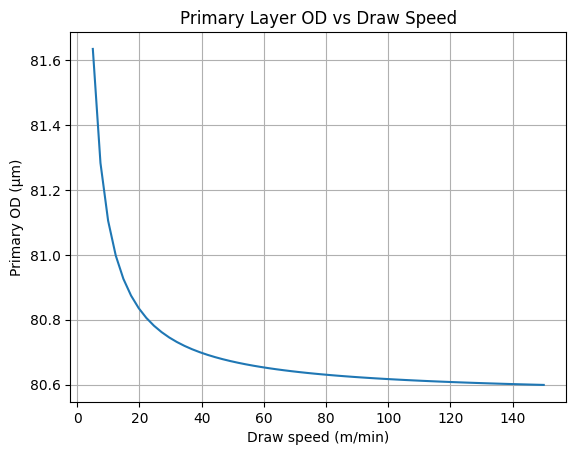

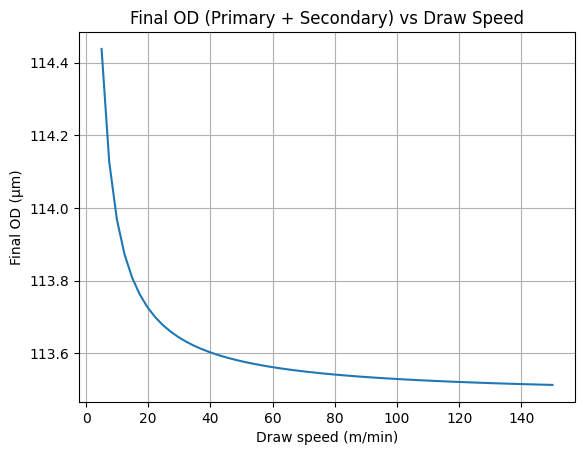

In [101]:
import numpy as np
import matplotlib.pyplot as plt

def sweep_speed_two_layer_od(
    speeds_m_min,
    fiber_d_um=40.0,

    # Layer 1
    coating1="DP-1032",
    T1_C=28.0,
    delta_p1_bar=0.3,
    R1_um=65.0,
    L1_um=2000.0,
    q1=1.0,
    sigma1_N_m=0.034,

    # Layer 2
    coating2="DS-2042",
    T2_C=28.0,
    delta_p2_bar=0.3,
    R2_um=75.0,
    L2_um=2000.0,
    q2=1.0,
    sigma2_N_m=0.0228,
):
    primary_od = []
    final_od = []

    for V in speeds_m_min:
        res = predict_two_layer_case_with_surface_check(
            fiber_d_um=fiber_d_um,
            V_m_min=float(V),

            coating1=coating1,
            T1_C=T1_C,
            delta_p1_bar=delta_p1_bar,
            R1_um=R1_um,
            L1_um=L1_um,
            q1=q1,
            sigma1_N_m=sigma1_N_m,

            coating2=coating2,
            T2_C=T2_C,
            delta_p2_bar=delta_p2_bar,
            R2_um=R2_um,
            L2_um=L2_um,
            q2=q2,
            sigma2_N_m=sigma2_N_m,

            verbose=False
        )

        t1 = res["t1_um"]
        t2 = res["t2_um"]

        primary_od.append(fiber_d_um + 2*t1)
        final_od.append(fiber_d_um + 2*(t1 + t2))

    return np.array(primary_od), np.array(final_od)


# ===============================================
# Speed range
# ===============================================

speeds = np.linspace(5, 150, 60)

od_primary, od_final = sweep_speed_two_layer_od(
    speeds,
    fiber_d_um=40.0,

    coating1="DP-1032", T1_C=28.0, delta_p1_bar=0.4, R1_um=65.0, L1_um=2000.0, q1=1.0, sigma1_N_m=0.034,
    coating2="DS-2042", T2_C=28.0, delta_p2_bar=0.4, R2_um=75.0, L2_um=2000.0, q2=1.0, sigma2_N_m=0.034,
)

# ===============================================
# Plot 1 — Primary OD
# ===============================================
plt.figure()
plt.plot(speeds, od_primary)
plt.xlabel("Draw speed (m/min)")
plt.ylabel("Primary OD (µm)")
plt.title("Primary Layer OD vs Draw Speed")
plt.grid(True)
plt.show()

# ===============================================
# Plot 2 — Final OD
# ===============================================
plt.figure()
plt.plot(speeds, od_final)
plt.xlabel("Draw speed (m/min)")
plt.ylabel("Final OD (µm)")
plt.title("Final OD (Primary + Secondary) vs Draw Speed")
plt.grid(True)
plt.show()